In [34]:
import numpy
from matplotlib import pyplot
import monte_carlo

In [35]:
edges =  [((0,1),-1.0), ((1,2), -1.0), ((2,3), -1.0), ((3,4), -1.0)]
biases = [1.0, 0.0, 0.0, 0.0, 0.0]
transverse = None

## Test beta

In [36]:
betas = [0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 20.0, 40.0]

In [37]:
q_data = numpy.zeros(len(betas))
for i, beta in enumerate(betas):
    results = monte_carlo.run_quantum_monte_carlo_and_measure_spins(beta, 1000000, 10, edges, biases, transverse_field=transverse, spin_measurement=(-1.0, 1.0), sampling_freq=25)
    q_data[i] = numpy.mean(results, axis=0)

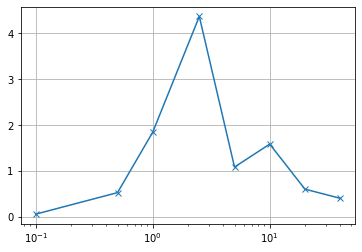

In [38]:
pyplot.plot(betas, q_data, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()

In [39]:
data = numpy.zeros(len(betas))
for i, beta in enumerate(betas):
    results = monte_carlo.run_monte_carlo(beta, 1000, 1000, edges, biases)
    results = numpy.asarray([state for _, state in results])
    results = numpy.sum((results * 2) - 1, axis=-1)
    data[i] = numpy.mean(results, axis=0)

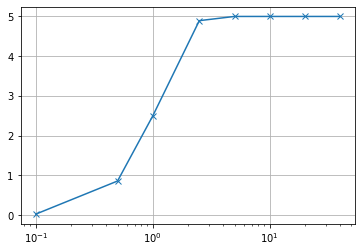

In [40]:
pyplot.plot(betas, data, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()

## Test convergence

In [41]:
timesteps = [10, 50, 100, 500, 1000, 5000, 10000]
beta = 5.0

In [42]:
q_data_conv = numpy.zeros(len(timesteps))
for i, ts in enumerate(timesteps):
    results = monte_carlo.run_quantum_monte_carlo_and_measure_spins(beta, ts, 1000, edges, biases, transverse_field=transverse, spin_measurement=(-1.0, 1.0))
    q_data_conv[i] = numpy.mean(results, axis=0)

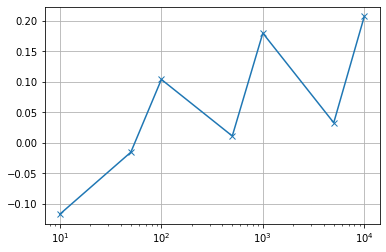

In [43]:
pyplot.plot(timesteps, q_data_conv, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()

In [44]:
data_conv = numpy.zeros(len(timesteps))
for i, beta in enumerate(timesteps):
    results = monte_carlo.run_monte_carlo(beta, ts, 1000, edges, biases)
    results = numpy.asarray([state for _, state in results])
    results = numpy.sum((results * 2) - 1, axis=-1)
    data_conv[i] = numpy.mean(results, axis=0)

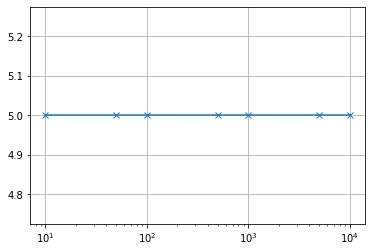

In [45]:
pyplot.plot(timesteps, data_conv, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()

## Exact Diagonalization

In [46]:
import scipy.linalg

In [47]:
ham = numpy.zeros((2**len(biases), 2**len(biases)))
for i in range(2**len(biases)):
    state = [(i >> j) & 1 for j in range(len(biases))]
    h = 0.0
    for s, b in zip(state, biases):
        if s:
            h -= b
    for (vara, varb), j in edges:
        if state[vara] == state[varb]:
            h += j
        else:
            h -= j
    ham[i,i] = h

spin_diag = []
for i in range(2**len(biases)):
    state = [(i >> j) & 1 for j in range(len(biases))]
    spin_diag.append(numpy.sum(numpy.asarray(state)*2 - 1))
spin_op = numpy.diag(spin_diag)

In [48]:
ed_data = []
for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    ed_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))

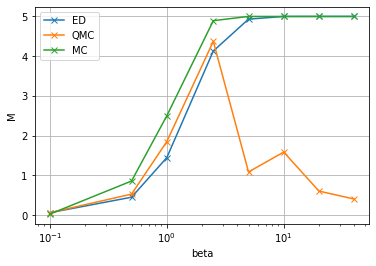

In [49]:
pyplot.plot(betas, ed_data, 'x-', label="ED")
pyplot.plot(betas, q_data, 'x-', label="QMC")
pyplot.plot(betas, data, 'x-', label="MC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("M")
pyplot.savefig("compare.png")
pyplot.show()

## Including Transverse field

In [29]:
edges =  [((0,1),-1.0), ((1,2), -1.0), ((2,3), -1.0), ((3,4), -1.0)]
biases = [1.0, 0.0, 0.0, 0.0, 0.0]
transverse_fields = [1.0, 1.0, 1.0, 1.0, 1.0]

In [30]:
q_transverse_data = numpy.zeros(len(betas))
for i, beta in enumerate(betas):
    results = monte_carlo.run_quantum_monte_carlo_and_measure_spins(beta, 1000000, 10, edges, biases, transverse_field=transverse_fields, spin_measurement=(-1.0, 1.0), sampling_freq=25)
    q_transverse_data[i] = numpy.mean(results, axis=0)

In [31]:
ham = numpy.zeros((2**len(biases), 2**len(biases)))
for i in range(2**len(biases)):
    state = [(i >> j) & 1 for j in range(len(biases))]
    h = 0.0
    for s, b in zip(state, biases):
        if s:
            h -= b
    for (vara, varb), j in edges:
        if state[vara] == state[varb]:
            h += j
        else:
            h -= j
    
    ham[i,i] += h
    for j in range(i+1, 2**len(biases)):
        b_state = [(j >> k) & 1 for k in range(len(biases))]
        diffstate = [a^b for a,b in zip(state, b_state)]
        if sum(diffstate) != 1:
            continue
        for vark,s in enumerate(diffstate):
            if not s:
                continue
            ham[i, j] += transverse_fields[vark]
            ham[j, i] += transverse_fields[vark]

spin_diag = []
for i in range(2**len(biases)):
    state = [(i >> j) & 1 for j in range(len(biases))]
    spin_diag.append(numpy.sum(numpy.asarray(state)*2 - 1))
spin_op = numpy.diag(spin_diag)

In [32]:
ed_transverse_data = []
for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    ed_transverse_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))

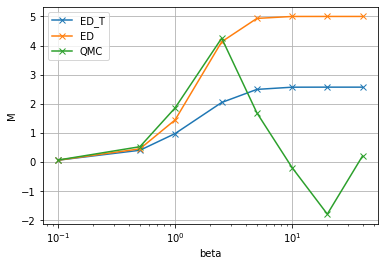

In [33]:
pyplot.plot(betas, ed_transverse_data, 'x-', label="ED_T")
pyplot.plot(betas, ed_data, 'x-', label="ED")
pyplot.plot(betas, q_transverse_data, 'x-', label="QMC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("M")
pyplot.savefig("compare.png")
pyplot.show()